### Building word2Vec model out of StackOverflow tags submitted with questions

This is a first attempt to build the word2Vec model based on StackOverflow tags using Gensim library.
Tags for a question are effectively considered as a sentence. As a result, the word2Vec model will have vectors for all (almost) tags, and we can run similarity tasks (and other ones such as clustering or 2-D plotting). 

word2Vec is probably an overkill for such problem. Most of the "sentences" are quite short. Also, probably buidling a co-occurence matrix already gives lots of insights. However, having word2Vec vectors may be interesting for some tasks, and it is definitely fun to play with this model.

by DataQubit, June 2019

In [ ]:
import numpy as np
import pandas as pd
import bq_helper
from bq_helper import BigQueryHelper
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
from IPython.display import HTML

In [166]:
def create_download_link(filename, title = "Download file"):
    """ generates a download line for the file"""
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [48]:
from gensim.models.word2vec import Word2Vec

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [ ]:
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

In [ ]:

# SQL query to extract tags
query_tags_count_dist = """
WITH tags_counts AS
    (SELECT ARRAY_LENGTH(SPLIT(tags, '|')) AS tag_count
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`)
SELECT tag_count, COUNT(1) AS tag_count_freq
FROM tags_counts
GROUP BY tag_count
ORDER BY tag_count;
""" 

In [ ]:
df_tags_cnt = stackOverflow.query_to_pandas_safe(query_tags_count_dist, max_gb_scanned=3.)

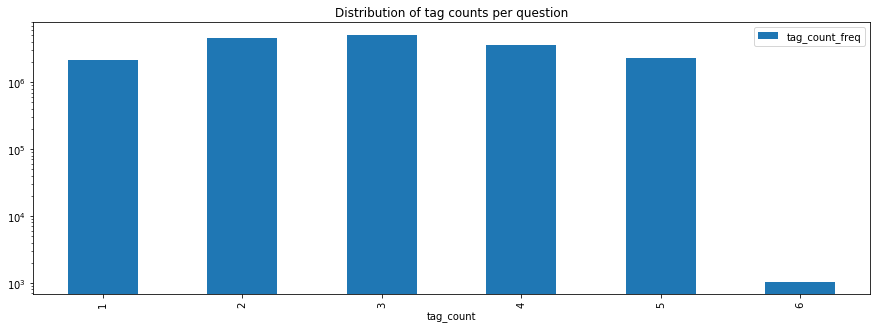

In [167]:
df_tags_cnt.set_index('tag_count').plot(kind='bar', logy=True, figsize=(15, 5), title='Distribution of tag counts per question')

### Training Word2Vec model with Gensim

In [110]:
# SQL query to extract tags
query_tags = """
SELECT SPLIT(tags, '|') AS tag_docs
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
WHERE ARRAY_LENGTH(SPLIT(tags, '|')) > 1
;
""" 

In [111]:
df_tags = stackOverflow.query_to_pandas_safe(query_tags, max_gb_scanned=3.)

In [113]:
len(df_tags)

15624584

In [112]:
df_tags.head()

,tag_docs
0,"[javascript, visual-studio-2012]"
1,"[c#, .net, wpf, xaml]"
2,"[android, android-activity, return]"
3,"[html, css]"
4,"[moodle, zoho]"


### Subsampling
Probability of including frequent words. As an example, a frequent tag 'python'.

In [168]:
f = df_tags.tag_docs.apply(lambda x: 'python' in x).mean()

In [169]:
t = 1.e-3
p = (f - t) / f - np.sqrt(t / f)
print(p)

0.866525083198421


### Initial parameters for word2Vec model:

In [117]:
num_features = 200
min_word_count = 10
num_workers = 4
window_size = 5
subsampling = 1e-3

In [118]:
model = Word2Vec(workers=num_workers,
                 size=num_features,
                 min_count=min_word_count,
                 window=window_size,
                 sample=subsampling)

#### Creating vocabulary

In [119]:
model.build_vocab(df_tags.tag_docs)

In [120]:
len(model.wv.vocab), model.wv.vectors.shape

(41716, (41716, 200))

#### Train the model

In [121]:
model.train(df_tags.tag_docs, total_examples=model.corpus_count, epochs=model.epochs)

(199668807, 252380340)

#### Save the model

In [162]:
model.save("word2vec_tag_model_Jun13")

In [163]:
ls -lth

total 99M
-rw-r--r-- 1 root root 99M Jun 13 21:40 word2vec_tag_model_Jun13
-rw-r--r-- 1 root root 199 Jun 13 18:09 __notebook_source__.ipynb


In [170]:
create_download_link('word2vec_tag_model_Jun13')

In [171]:
model.similarity('python', 'algorithm')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.17026077

In [155]:
model.wv.most_similar(['python', 'pandas'], negative=['r'])

[('python-2.5', 0.582546055316925),
 ('python-2.x', 0.568282961845398),
 ('python-collections', 0.5630738139152527),
 ('python-2to3', 0.5589619874954224),
 ('python-3.4', 0.5543420314788818),
 ('nonetype', 0.5505074262619019),
 ('python-2.7', 0.5493074655532837),
 ('python-3.2', 0.5432831048965454),
 ('python-3.3', 0.5422384142875671),
 ('keyerror', 0.5402590036392212)]

In [172]:
model.wv.most_similar(['python'])

[('python-2.7', 0.5931922197341919),
 ('python-3.x', 0.5709347128868103),
 ('python-3.4', 0.5448521375656128),
 ('python-3.5', 0.5288998484611511),
 ('python-3.6', 0.5224025249481201),
 ('python-3.2', 0.5222942233085632),
 ('python-2.x', 0.5185912847518921),
 ('python-3.3', 0.5176692008972168),
 ('python-2.5', 0.5155071020126343),
 ('attributeerror', 0.5062666535377502)]

In [173]:
model.wv.doesnt_match(list("browser google-chrome firefox html javascript machine-learning".split()))

/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'machine-learning'

In [174]:
model.wv.similarity('python', 'java')

0.19769649

#### Other Experiments:

1. Using t-SNE (or PCA) to plot a number of most popular tags on a 2-D scatter plot.
2. Find interesting vector combinations.